# Product Sentiment Classifier

## Data Cleaning and EDA
Import necessary libraries

In [1]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist
from nltk import FreqDist
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, 
                             plot_confusion_matrix)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import keras
from keras import models
from keras import layers
from keras import optimizers

%run -i "clean_lemmatize_token.py"
%run -i "report.py"

Using TensorFlow backend.


Import data from data.world.

In [2]:
df = pd.read_csv('https://query.data.world/s/zbehvjkmiewbkln44rae6iphum4v3g', 
                 encoding = "ISO-8859-1")
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Rename columns

In [3]:
df=df.rename(columns = {'emotion_in_tweet_is_directed_at':
                        'brand_product',
                        'is_there_an_emotion_directed_at_a_brand_or_product':
                        'sentiment'})
df.head()

,tweet_text,brand_product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Explored data set with info() method. 1 NaN value present in tweet_text column and ~6,000 in brand_product column. Will need to address prior to modeling

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text       9092 non-null object
brand_product    3291 non-null object
sentiment        9093 non-null object
dtypes: object(3)
memory usage: 213.2+ KB


Remove NaN tweet_text from DataFrame

In [5]:
df[df['tweet_text'].isna()]

,tweet_text,brand_product,sentiment
6,NaN,NaN,No emotion toward brand or product


In [6]:
df.drop(inplace= True, index=6)

### Exploration
Explored Sentiment category. Most tweets are marked as having No emotion which will not help initial binary classification model. Most data in data set will only be usuable when model is built to take into account neutral sentiment

In [7]:
df.groupby('sentiment').count()

,tweet_text,brand_product
sentiment,,
I can't tell,156,9
Negative emotion,570,519
No emotion toward brand or product,5388,91
Positive emotion,2978,2672


In [8]:
df.loc[df['sentiment'] == "I can't tell"]

,tweet_text,brand_product,sentiment
90,Thanks to @mention for publishing the news of ...,NaN,I can't tell
102,ÛÏ@mention &quot;Apple has opened a pop-up st...,NaN,I can't tell
237,Just what America needs. RT @mention Google to...,NaN,I can't tell
341,The queue at the Apple Store in Austin is FOUR...,NaN,I can't tell
368,Hope it's better than wave RT @mention Buzz is...,NaN,I can't tell
...,...,...,...
9020,It's funny watching a room full of people hold...,NaN,I can't tell
9032,"@mention yeah, we have @mention , Google has n...",NaN,I can't tell
9037,"@mention Yes, the Google presentation was not ...",NaN,I can't tell
9058,&quot;Do you know what Apple is really good at...,NaN,I can't tell


In [9]:
df['sentiment'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

Dummied Sentiment Column to help with visulizations to compare sentiment across brands

In [10]:
df1=pd.get_dummies(df['sentiment'])
df1.head()

,I can't tell,Negative emotion,No emotion toward brand or product,Positive emotion
0,0,1,0,0
1,0,0,0,1
2,0,0,0,1
3,0,1,0,0
4,0,0,0,1


In [11]:
df_dummied=df.join(df1).drop(columns='sentiment')
df_dummied.head()

,tweet_text,brand_product,I can't tell,Negative emotion,No emotion toward brand or product,Positive emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,1,0,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,0,0,0,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,0,0,0,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,1,0,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,0,0,0,1


Made visualization to explore distribution of sentiment across brand/product. Will combine Apple and Google products to further explore distribution. Sentiment is overwhelmingly positive across all products and most sentiment data is logged for Apple products

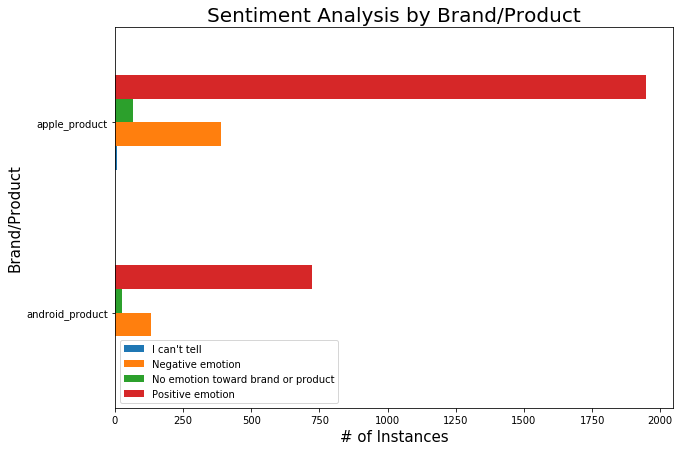

In [33]:
df_dummied.groupby('brand_product').sum().plot(kind='barh', 
                                               figsize=(10,7))
plt.title('Sentiment Analysis by Brand/Product', size=20)
plt.ylabel('Brand/Product', size=15)
plt.xlabel('# of Instances', size=15)
plt.savefig('figures/SentimentbyProduct.png')
plt.show()

Made below visualization to explore the missing brand_product classifications for each sentiment

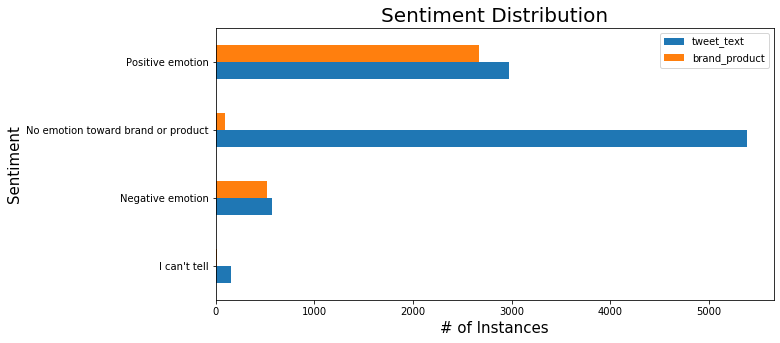

In [13]:
df.groupby('sentiment').count().plot(kind='barh',
                                     figsize=(10,5))
plt.title('Sentiment Distribution', size=20)
plt.ylabel('Sentiment', size=15)
plt.xlabel('# of Instances',size=15)
plt.show()

Usable data (Positive or Negative sentiment) for baseline first model is 39.02%. Will be necessary to eventually build a multiclass classifier with No Emotion classification

In [14]:
usable_data=round(len(df.loc[(df['sentiment'] == 'Positive emotion') | 
                             (df['sentiment'] == 'Negative emotion')])/len(df) * 100,2)
print('Percentage of Data with either Positive or Negative Sentiment: {}%'.format(usable_data))

Percentage of Data with either Positive or Negative Sentiment: 39.02%


Combined Apple and Google product names together to explore further visualizations

In [15]:
df_dummied['brand_product']=df_dummied['brand_product'].replace(to_replace = ['iPad','Apple',
                                                                                    'iPad or iPhone App','iPhone',
                                                                                    'Other Apple product or service'],value='apple_product')
df_dummied['brand_product'] = df_dummied['brand_product'].replace(['Google',
                                                                        'Other Google product or service',
                                                                        'Android App', 'Android'],'android_product')
df_dummied['brand_product'].value_counts()

apple_product      2409
android_product     882
Name: brand_product, dtype: int64

Combined Brand_product columns to show difference in amount of information for each product

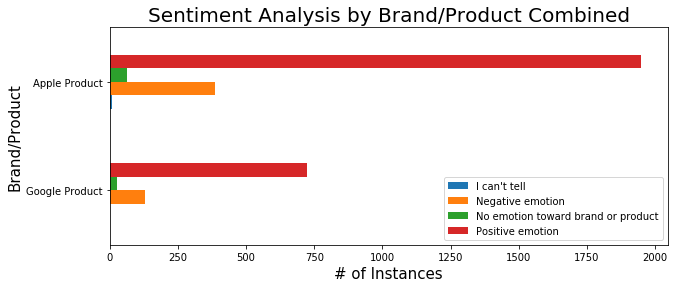

In [16]:
df_dummied.groupby('brand_product').sum().plot(kind='barh', figsize=(10,4))
plt.title('Sentiment Analysis by Brand/Product Combined', size=20)
plt.ylabel('Brand/Product', size=15)
plt.xlabel('# of Instances', size=15)
plt.yticks(np.arange(2),['Google Product','Apple Product'])
plt.show()

### Preprocessing Tweets
Clean, lemmatize, and format data for vectorization and modeling

In [17]:
df['tweet_text'] = df['tweet_text'].map(clean_lemmatize_token)

### binary classification model
Split the DataFrame to take only binary options 

In [18]:
binary = df[(df['sentiment'] == 'Negative emotion')|
            (df['sentiment'] == 'Positive emotion')]

vectorize the data

In [19]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(binary['tweet_text'])
Y = binary['sentiment']
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2)

### Logistic Regression

C:\Users\Shawn\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Shawn\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Shawn\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Shawn\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Shawn\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

                  precision    recall  f1-score   support

Negative emotion       0.62      0.66      0.64       113
Positive emotion       0.94      0.92      0.93       597

        accuracy                           0.88       710
       macro avg       0.78      0.79      0.79       710
    weighted avg       0.89      0.88      0.88       710



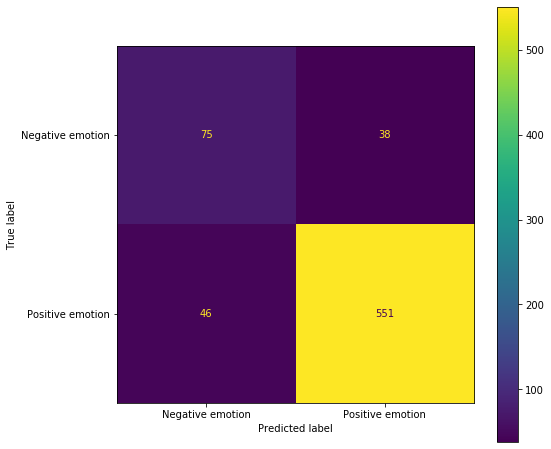

In [20]:
params= {'solver': ['lbfgs', 'liblinear', 'sag', 'saga'], 
         'max_iter': [500, 600],
         'C': [.2, .4, .6, .8, 1], 
         'tol': [.0001, .001, .01],
         'class_weight': ['balanced']}
log_grid = GridSearchCV(LogisticRegression(), 
                        param_grid= params)
report(log_grid)

### Decision Tree Classifier

                  precision    recall  f1-score   support

Negative emotion       0.58      0.40      0.47       113
Positive emotion       0.89      0.95      0.92       597

        accuracy                           0.86       710
       macro avg       0.74      0.67      0.70       710
    weighted avg       0.84      0.86      0.85       710



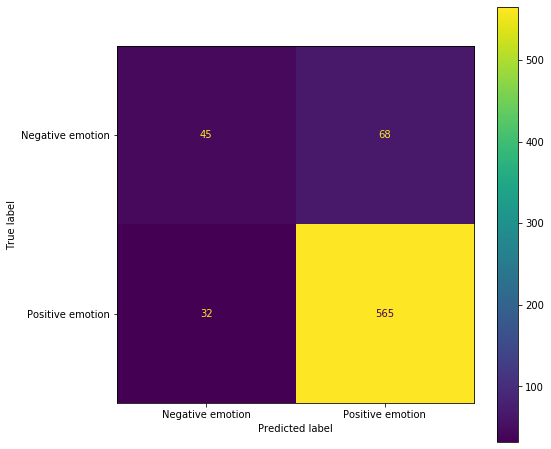

In [21]:
params= {'criterion': ['gini', 'entropy'], 
         'splitter': ['best', 'random'], 
         'max_depth': [50, 80, 100, None], 
         'class_weight': ['balanced', None]}
grid_tree = GridSearchCV(DecisionTreeClassifier(), 
                         param_grid=params) 

report(grid_tree)

### Recurrent Neural Networks

In [29]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(nb_words = 200)
tokenizer.fit_on_texts(binary['tweet_text'].values)
X = tokenizer.texts_to_sequences(binary['tweet_text'].values)
X = pad_sequences(X)

In [22]:
lstm = tf.keras.layers.LSTM(4)
output = lstm(X_train)

AttributeError: 'tuple' object has no attribute 'ndims'

In [ ]:
model = models.Sequential()
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(25, activation='relu'))
model.compile(optimizer='SGD', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
history = model.fit(X_train,
                    y_train,
                    epochs=120,
                    batch_size=256)
history_dict = history.history
history_dict = history.history
loss_values = history_dict['loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()